## LAB CHALLENGE: Neural Matrix Factorization 
In the previous lecture we have built a recommender system using the Neural Matrix Factorization framework. This framework allowed us to combine the GMF layers with the MLP layers in this way:
$$\phi^{GMF} = \mathbf{p_u}^G\odot \mathbf{q_i}^G$$
$$\phi^{MLP} = a_L(\mathbf{W}_L^T(a_{L-1}(...a_2 (\mathbf{W}_2^T \begin{bmatrix}
\mathbf{p_u} \\ \mathbf{q_i}
\end{bmatrix} + \mathbf{b}_2)...)) + \mathbf{b}_L)$$

$$ y_{ui} = \sigma(\mathbf{h}^T \begin{bmatrix}
\ \phi^{GMF} \\ \phi^{MLP}
\end{bmatrix})$$

<center>  <img src="https://drive.google.com/uc?export=view&id=1gNLUpiQdbDPMdvfZYVs3lcou3cd4Favb" width="550" height="400"> </center> 

Let's now try to apply transfer learning to such an architecture. 

- TASK 1: Train the GMF and MLP models separately, inspect and save the parameters.
- TASK 2: Use the pre-trained parameters for initializing the NMF architecture. In particular, use the pre-trained embeddings for users and items and the initialized layers of GMF and MLP.
- TASK 3: Finally, train the NMF model both by freezing the layers preceding the NeuMF layer and by keeping all the parameters trainable. Compare the performance with the network trained from scratch.


In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
#from ray import tune
#from ray.tune import CLIReporter
#from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import DataLoader
import time

from neumf import NeuMF
from metrics import metrics
from NCF_Data import NCF_Data
from dl import data_loaders_from_data

/home/agoniko/Desktop/Uni/DEEP_LEARNING/Transfer Learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## PATH definition

In [2]:
PATH = "./ml-100k/u.data" 
MODEL_PATH = "./models/" 

## Parameters Definition

In [26]:
args = {
    "seed": 0,
    "lr": 0.01,
    "dropout": 0.2,
    "batch_size": 128,
    "epochs": 30,
    "top_k": 10,
    "num_factors": 32,
    "layers": (64, 32, 16, 8),
    "out": True,
    "num_ng": 4,
    "num_ng_test": 100
}

In [4]:
best_config = {
    "lr": 0.01,
    "batch_size": 128,
    "num_factors_gmf": 16,
    "num_factors_mlp": 64,
    "epochs": 30,
    "out": True,
    "dropout": [0, 0, 0, 0],
}

In [27]:
np.random.seed(args["seed"])
torch.manual_seed(args["seed"])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

## Load Train and Test loaders

In [28]:
# load data
ml_100k = pd.read_csv(
	PATH, 
	sep="\t", 
	names = ['user_id', 'item_id', 'rating', 'timestamp'], 
	engine='python')

# set the num_users, items
num_users = ml_100k['user_id'].nunique()+1
num_items = ml_100k['item_id'].nunique()+1

# construct the train and test datasets
data = NCF_Data(ml_100k, args)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

In [12]:
#_, _, train_loader, _ = data_loaders_from_data(PATH, best_config["batch_size"])

# Models

In [30]:
def train_model(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader, optimizer = None, name_suffix = ""):
    model = model.to(device)

    # Loss and optimizer
    loss_function = nn.BCELoss()
    if optimizer == None:
        optimizer = optim.Adam(model.parameters(), lr=args["lr"])

    best_hr = 0
    
    # Train cycle
    for epoch in range(args["epochs"]):
        start_time = time.time()
        
        # Train step
        model.train()

        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            # Zero grad
            optimizer.zero_grad()
            
            # Prediction
            prediction = model(user, item)
            loss = loss_function(prediction, label)
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Eval metrics
        model.eval()
        HR, NDCG = metrics(model, test_loader, args["top_k"], device)

        # Print metrics and time elapsed
        elapsed_time = time.time() - start_time
        print(
            "Epoch {:03d}".format(epoch)
            + " time to train: "
            + time.strftime("%H: %M: %S", time.gmtime(elapsed_time))
        )
        print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

        # If best model, save it
        if HR > best_hr:
            best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
            if args["out"]:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                torch.save(
                    model, "{}{}{}.pt".format(MODEL_PATH, model.__class__.__name__, model.num_factors, name_suffix)
                )


## GMF model

In [31]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]

        self.embedding_user = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.num_factors
        )
        self.embedding_item = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.num_factors
        )

        self.affine_output = nn.Linear(in_features=self.num_factors, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating.squeeze()


In [33]:
#gmf_model = GMF(num_users, num_items)
#train_model(gmf_model, train_loader, test_loader)
gmf_model = torch.load(MODEL_PATH + "GMF8.pt", map_location=device)

## MLP model

In [34]:
class MLP(nn.Module):
    def __init__(self, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]

        self.embedding_user = nn.Embedding(
            num_embeddings=num_users, embedding_dim=args["num_factors"]
        )
        self.embedding_item = nn.Embedding(
            num_embeddings=num_items, embedding_dim=args["num_factors"]
        )

        layer_sizes = args["layers"]
        layers = []
        layers.append(nn.Linear(args["num_factors"] * 2, layer_sizes[0]))
        #layers.append(nn.ReLU())
        for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ReLU())
        self.mlp_fc = nn.Sequential(*layers)
        self.mlp_fc.add_module("affine", nn.Linear(layer_sizes[-1], 1))
        self.mlp_fc.add_module("logit", nn.Sigmoid())

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        rating = self.mlp_fc(vector)
        return rating.squeeze()


In [35]:
"""args["lr"] = 0.01
args["dropout"] = 0
args["num_factors"] = 64
args['layers'] = [32, 16, 8]
mlp_model = MLP(num_users, num_items)
train_model(mlp_model, train_loader, test_loader)"""
mlp_model = torch.load(MODEL_PATH + "MLP64.pt", map_location=device)

## NeuMF model

In [ ]:
#nmf_model = torch.load(MODEL_PATH + "Assignment 1 - best.pt", map_location=device)
nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)
train_model(nmf_model, train_loader, test_loader)

# Defining functions that load sub_models weights

In [12]:
def load_gmf_weights(nmf_model, gmf_model, requires_grad=False):
    nmf_layers_names = [name for name, param in nmf_model.named_parameters()]
    gmf_layers_names = [name for name, param in gmf_model.named_parameters()]
    #create a dict that has as key the value of the layer in the NMF model and as value the layer in the GMF model
    layers_name_match_dict = {k: v for k, v in zip(nmf_layers_names[:2], gmf_layers_names)}
    for nmf_layer_name, gmf_layer_name in layers_name_match_dict.items():
        nmf_model.state_dict()[nmf_layer_name].copy_(gmf_model.state_dict()[gmf_layer_name])
    #deactivate grad for the layers that comes from the GMF model
    for name, param in nmf_model.named_parameters():
        if name in layers_name_match_dict.keys():
            param.requires_grad = requires_grad


def load_mlp_weights(nmf_model, mlp_model, requires_grad=False):
    nmf_layers_names = [name for name, param in nmf_model.named_parameters()]
    mlp_layers_names = [name for name, param in mlp_model.named_parameters()]
    #create a dict that has as key the value of the layer in the NMF model and as value the layer in the MLP model
    layers_name_match_dict = {k: v for k, v in zip(nmf_layers_names[4:], mlp_layers_names[:-2])}
    for nmf_layer_name, mlp_layer_name in layers_name_match_dict.items():
        nmf_model.state_dict()[nmf_layer_name].copy_(mlp_model.state_dict()[mlp_layer_name])
    #deactivate grad for the layers that comes from the MLP model
    for name, param in nmf_model.named_parameters():
        if name in layers_name_match_dict.keys():
            param.requires_grad = requires_grad


def load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad = False):
    load_gmf_weights(nmf_model, gmf_model, requires_grad)
    load_mlp_weights(nmf_model, mlp_model, requires_grad)

# Performance with sum_models layers freezed

In [41]:
nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)

In [42]:
list(nmf_model.named_parameters())[0][1]

Parameter containing:
tensor([[ 0.0549, -0.8033,  0.5348,  ...,  0.5876, -0.3337,  1.1686],
        [ 1.8670,  0.2206,  1.7604,  ...,  1.0887, -1.5087,  0.8907],
        [ 0.4705, -0.2217,  0.8257,  ...,  0.3822,  0.7008, -1.6287],
        ...,
        [-0.4775,  0.5651,  0.6419,  ...,  0.6401,  0.6765, -0.8220],
        [ 0.7061,  1.2536,  0.2003,  ..., -0.4080,  0.7981,  0.2762],
        [-1.5128, -0.0406,  0.1531,  ..., -0.4135, -0.6233, -0.2396]],
       requires_grad=True)

In [43]:
load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad=False)

In [44]:
list(nmf_model.named_parameters())[0][1]


Parameter containing:
tensor([[-0.1514,  0.4690,  0.6961,  ...,  0.8707, -0.4645, -0.1457],
        [ 0.2311,  0.8680, -0.6166,  ...,  1.5733, -0.4352,  0.3049],
        [-0.1804,  1.0708,  0.9530,  ...,  0.9818,  1.4919,  0.7378],
        ...,
        [-2.6230,  0.1944, -0.3794,  ..., -0.5907, -0.1775, -0.0250],
        [-0.3618,  1.9552,  0.1007,  ...,  0.6635, -0.0256, -1.0146],
        [-0.4400,  2.0753, -0.6651,  ..., -0.6961,  0.1153,  1.3355]])

In [45]:
for name, param in nmf_model.named_parameters():
    print(name, param.requires_grad)

gmf_user_embed.0.weight False
gmf_item_embed.0.weight False
gmf_affine.weight True
gmf_affine.bias True
mlp_user_embed.0.weight False
mlp_item_embed.0.weight False
mlp_fc.0.weight False
mlp_fc.0.bias False
mlp_fc.3.weight False
mlp_fc.3.bias False
mlp_fc.6.weight False
mlp_fc.6.bias False
mlp_fc.9.weight False
mlp_fc.9.bias False
mixing_layers.0.weight True
mixing_layers.0.bias True
mixing_layers.3.weight True
mixing_layers.3.bias True
mixing_layers.6.weight True
mixing_layers.6.bias True


In [ ]:
train_model(nmf_model, train_loader, test_loader)

# Performance letting initialized layers free

In [47]:
nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)
load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad=True)
for name, param in nmf_model.named_parameters():
    print(name, param.requires_grad)

gmf_user_embed.0.weight True
gmf_item_embed.0.weight True
gmf_affine.weight True
gmf_affine.bias True
mlp_user_embed.0.weight True
mlp_item_embed.0.weight True
mlp_fc.0.weight True
mlp_fc.0.bias True
mlp_fc.3.weight True
mlp_fc.3.bias True
mlp_fc.6.weight True
mlp_fc.6.bias True
mlp_fc.9.weight True
mlp_fc.9.bias True
mixing_layers.0.weight True
mixing_layers.0.bias True
mixing_layers.3.weight True
mixing_layers.3.bias True
mixing_layers.6.weight True
mixing_layers.6.bias True


In [48]:
train_model(nmf_model, train_loader, test_loader)

Epoch 000 time to train: 00: 00: 18
HR: 0.652	NDCG: 0.379
Epoch 001 time to train: 00: 00: 27
HR: 0.630	NDCG: 0.362
Epoch 002 time to train: 00: 00: 25
HR: 0.634	NDCG: 0.370
Epoch 003 time to train: 00: 00: 21
HR: 0.630	NDCG: 0.372
Epoch 004 time to train: 00: 00: 23
HR: 0.627	NDCG: 0.366
Epoch 005 time to train: 00: 00: 24
HR: 0.619	NDCG: 0.362
Epoch 006 time to train: 00: 00: 21
HR: 0.636	NDCG: 0.367
Epoch 007 time to train: 00: 00: 23
HR: 0.645	NDCG: 0.369
Epoch 008 time to train: 00: 00: 24
HR: 0.629	NDCG: 0.368
Epoch 009 time to train: 00: 00: 23
HR: 0.639	NDCG: 0.378
Epoch 010 time to train: 00: 00: 21
HR: 0.636	NDCG: 0.366
Epoch 011 time to train: 00: 00: 22
HR: 0.621	NDCG: 0.352
Epoch 012 time to train: 00: 00: 21
HR: 0.629	NDCG: 0.354
Epoch 013 time to train: 00: 00: 21
HR: 0.628	NDCG: 0.361
Epoch 014 time to train: 00: 00: 21
HR: 0.620	NDCG: 0.355
Epoch 015 time to train: 00: 00: 21
HR: 0.633	NDCG: 0.358
Epoch 016 time to train: 00: 00: 21
HR: 0.627	NDCG: 0.361
Epoch 017 time

KeyboardInterrupt: 

# Performance comparison

In [51]:
nmf_freezed = torch.load(MODEL_PATH + "NeuMF64-freezed.pt", map_location = device)
gmf_best = torch.load(MODEL_PATH + "GMF8.pt", map_location = device)
mlp_best = torch.load(MODEL_PATH + "MLP64.pt", map_location = device)
nmf_free = torch.load(MODEL_PATH + "NeuMF64-free.pt", map_location = device)
nmf_init = torch.load(MODEL_PATH + "scratch.pt", map_location = device)

nmf_freezed.to(device) 
gmf_best.to(device) 
mlp_best.to(device)
nmf_free.to(device) 
nmf_init.to(device)

HR, NDCG = {}, {}
HR['NeuMF - freezed'], NDCG['NeuMF - freezed'] = metrics(nmf_freezed, test_loader, 10, device)
HR['NeuMF - free'], NDCG['NeuMF - free'] = metrics(nmf_free, test_loader, 10, device)
HR['NeuMF - init'], NDCG['NeuMF - init'] = metrics(nmf_init, test_loader, 10, device)
HR['GMF'], NDCG['GMF'] = metrics(gmf_best, test_loader, 10, device)
HR['MLP'], NDCG['MLP'] = metrics(mlp_best, test_loader, 10, device)

Text(0.5, 1.0, 'Best NDCG across models')

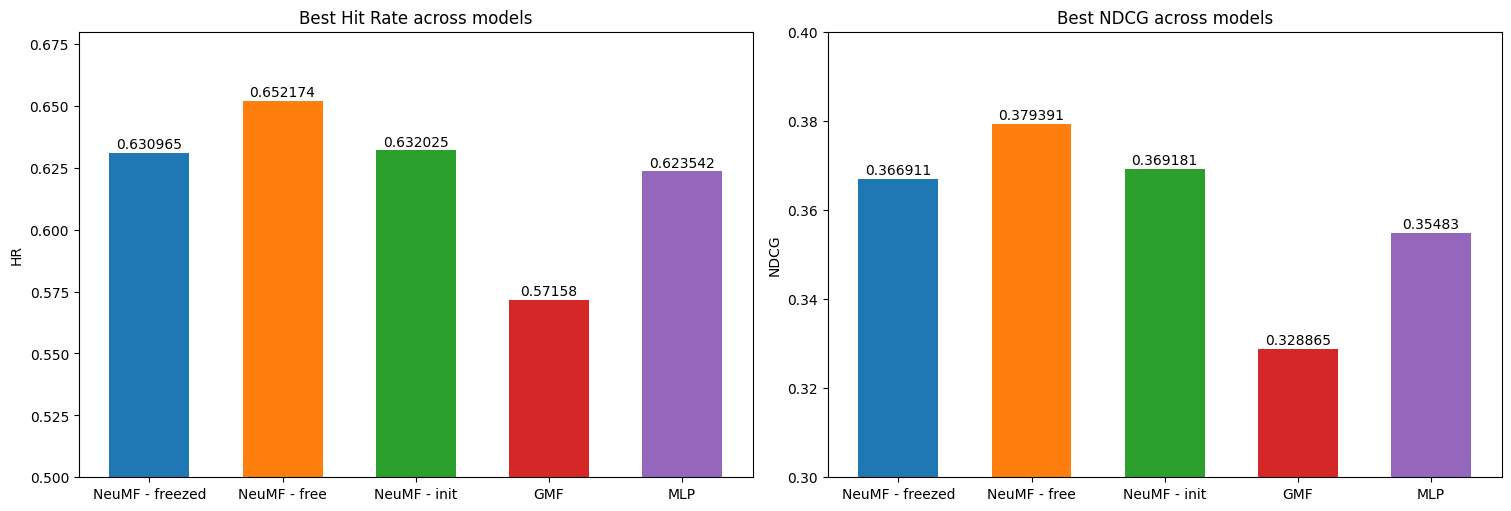

In [52]:
fig, ax = plt.subplots(1, 2, layout = "constrained", figsize = (15, 5))
for model, value in HR.items():
    rect = ax[0].bar(model, value, width= 0.6)
    ax[0].bar_label(rect, padding = 1)

ax[0].set_ylabel("HR")
ax[0].set_ylim(0.5, 0.68)
ax[0].set_title("Best Hit Rate across models")

for model, value in NDCG.items():
    rect = ax[1].bar(model, value, width= 0.6)
    ax[1].bar_label(rect, padding = 1)

ax[1].set_ylabel("NDCG")
ax[1].set_ylim(0.3, 0.40)
ax[1].set_title("Best NDCG across models")